# NLP Model


### Using Natural Language Processing for prediction of sentiments in news headline

#### Loading required libraries

In [82]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
default-jre is already the newest version (2:1.11-72build2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
openjdk version "11.0.22" 2024-01-16
OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1)
OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)


In [2]:
!pip install h2o

In [3]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install datatable
!pip install polars pyarrow

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



from h2o.automl import H2OAutoML

pd.set_option('max_colwidth', 100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgdupcjga
  JVM stdout: /tmp/tmpgdupcjga/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgdupcjga/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_unknownUser_0r1ht7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Reading the data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Reading data
path = "/content/drive/MyDrive/Colab Notebooks/SEntFiN-v1.1.csv"
df = pd.read_csv(path, usecols=['Title', 'Decisions'])

In [8]:
df

,Title,Decisions
0,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}"
1,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}"
2,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}"
3,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}"
4,"Market seeing patience, if not conviction: Prakash Diwan","{""Market"": ""neutral""}"
...,...,...
10748,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}"
10749,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""positive""}"
10750,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}"
10751,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}"


## Cleaning data

In [9]:
df = df.drop_duplicates()
df

,Title,Decisions
0,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}"
1,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}"
2,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}"
3,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}"
4,"Market seeing patience, if not conviction: Prakash Diwan","{""Market"": ""neutral""}"
...,...,...
10748,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}"
10749,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""positive""}"
10750,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}"
10751,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}"


In [10]:
def extract_sentiment(row):
    try:
        row_dict = json.loads(row)
        for value in row_dict.values():
            if value in ['neutral', 'negative', 'positive']:
                return value
    except json.JSONDecodeError:
        pass

# Create a copy of the DataFrame
df = df.copy()

# Apply the function to the copy
df['sentiment'] = df['Decisions'].apply(extract_sentiment)

# Drop the original column from the copy
df.drop(columns=['Decisions'], inplace=True)

df

,Title,sentiment
0,SpiceJet to issue 6.4 crore warrants to promoters,neutral
1,MMTC Q2 net loss at Rs 10.4 crore,neutral
2,"Mid-cap funds can deliver more, stay put: Experts",positive
3,Mid caps now turn into market darlings,positive
4,"Market seeing patience, if not conviction: Prakash Diwan",neutral
...,...,...
10748,"Negative on Chambal, Advanta: Mitesh Thacker",negative
10749,"Small, Mid-cap stocks may emerge outperformers",positive
10750,Rupee slips against US dollar,negative
10751,Rupee weak against US dollar,negative


## EDA

In [11]:
df['sentiment'].value_counts()

sentiment
positive    4155
neutral     3411
negative    3132
Name: count, dtype: int64

<Axes: xlabel='sentiment'>

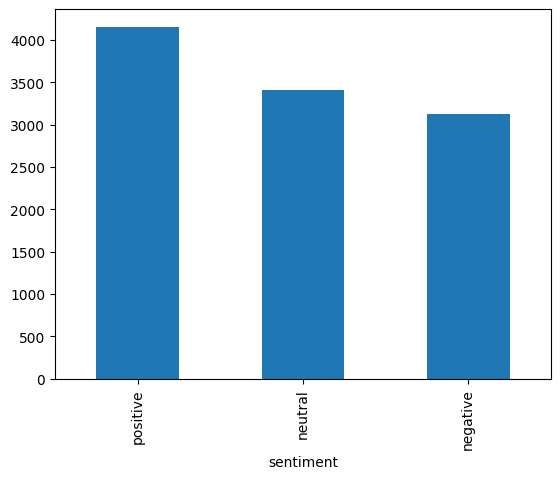

In [12]:
df['sentiment'].value_counts().plot(kind='bar')

In [13]:
sentiment_num={'neutral':0, 'positive':1, 'negative': 2}

In [14]:
df['sentiment_num']=df['sentiment'].map(sentiment_num)

In [15]:
df

,Title,sentiment,sentiment_num
0,SpiceJet to issue 6.4 crore warrants to promoters,neutral,0
1,MMTC Q2 net loss at Rs 10.4 crore,neutral,0
2,"Mid-cap funds can deliver more, stay put: Experts",positive,1
3,Mid caps now turn into market darlings,positive,1
4,"Market seeing patience, if not conviction: Prakash Diwan",neutral,0
...,...,...,...
10748,"Negative on Chambal, Advanta: Mitesh Thacker",negative,2
10749,"Small, Mid-cap stocks may emerge outperformers",positive,1
10750,Rupee slips against US dollar,negative,2
10751,Rupee weak against US dollar,negative,2



## Processing the data

In [16]:
X = df['Title']
y = df['sentiment_num']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shape of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8558,)
X_test shape: (2140,)
y_train shape: (8558,)
y_test shape: (2140,)


In [17]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = np.unique(df['sentiment'])
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=df['sentiment'].values)
class_weights = dict(zip(class_labels, weights))

print(class_weights)

{'negative': 1.1385696040868454, 'neutral': 1.0454412195836997, 'positive': 0.858243080625752}


In [18]:
df['sentiment_num'].value_counts()

sentiment_num
1    4155
0    3411
2    3132
Name: count, dtype: int64

In [20]:
stemmer=PorterStemmer
stemmer= nltk.stem.SnowballStemmer('english')

In [21]:
def preprocess(ex):
    if isinstance(ex, str):  # Check if ex is a string
        # Change sentence to lower case
        ex = ex.lower()

        # Tokenize into words
        words = word_tokenize(ex)

        # Prepare the stop words
        stop_words = set(stopwords.words("english"))

        # Exclude specific stop words
        exclusions = {'up', 'down', 'at', 'by', 'above', 'below'}
        stop_words = stop_words - exclusions

        # Remove stop words
        words = [word for word in words if word not in stop_words]

        # Join words to make sentence
        ex = " ".join(words)

    return ex

# Apply the preprocess function to the entire DataFrame
df = df.applymap(preprocess)

df

,Title,sentiment,sentiment_num,equalized_weights
0,spicejet issue 6.4 crore warrants promoters,neutral,0,1.0
1,mmtc q2 net loss at rs 10.4 crore,neutral,0,1.0
2,"mid-cap funds deliver , stay put : experts",positive,1,1.0
3,mid caps turn market darlings,positive,1,1.0
4,"market seeing patience , conviction : prakash diwan",neutral,0,1.0
...,...,...,...,...
10748,"negative chambal , advanta : mitesh thacker",negative,2,1.0
10749,"small , mid-cap stocks may emerge outperformers",positive,1,1.0
10750,rupee slips us dollar,negative,2,1.0
10751,rupee weak us dollar,negative,2,1.0


In [22]:
def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text)]
  tokens = map(str.lower, tokens)
  stems = [stemmer.stem(item) for item in tokens]
  return stems

## H2o Model

In [23]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, max_features=1400, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
train_vectors.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
feature_names = vectorizer_tf.get_feature_names_out()
feature_names

array(['$', '%', '% ,', ..., 'yuan', 'zee', 'zoom'], dtype=object)

In [28]:
test_vectors = vectorizer_tf.transform(X_test)

In [29]:
X_train.shape

(8558,)

In [31]:
train_df = pd.DataFrame(train_vectors.toarray(), columns=feature_names)
train_df = pd.concat([train_df, pd.DataFrame({'sentiment_num': y_train.reset_index(drop=True)})], axis=1)
train_df

,$,%,"% ,",% ;,% after,% as,% at,% in,% on,% post,...,year :,yen,yes,yes bank,yield,you,yuan,zee,zoom,sentiment_num
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [32]:
test_df = pd.DataFrame(test_vectors.toarray(), columns=feature_names)
test_df = pd.concat([test_df, pd.DataFrame({'sentiment_num': y_test.reset_index(drop=True)})], axis=1)
test_df

,$,%,"% ,",% ;,% after,% as,% at,% in,% on,% post,...,year :,yen,yes,yes bank,yield,you,yuan,zee,zoom,sentiment_num
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.404832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,0.152388,0.0,0.0,0.0,0.0,0.0,0.0,0.235606,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,0.278404,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2136,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2137,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2138,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [33]:
# Convert DataFrame to H2OFrame
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

# Display the converted H2OFrames
print("Train H2OFrame:")
print(h2o_train_df.head())
print("\nTest H2OFrame:")
print(h2o_test_df.head())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Train H2OFrame:
  $    %    % ,    % ;    % after    % as    % at    % in    % on    % post    % stake    % to    % upsid    &    & m    & o    & p    & t         '    's          ,    , 2014    , angel    , aptart    , bank    , but    , edelweiss    , euro    , global    , hit    , icici    , market    , nifti    , oil    , pharma     , say    , sensex    , silver    , stock    , tata    , to    .    1    10    10 %    10-year       100    11    12    12 %    13    13 %    14    14 %    15    15 %    16    17    18    19    2    2 %    20    20 %    20 trade    200    2013    2014    2014 :    2015    21    22    23    25    26    28    29    3    3 %    30    30 %    300    31    35    4    4 %    40    5    5 %    50    50 %    500    52-week    52-week high    6    6 %    60    7    7 %    8   

In [34]:
h2o_train_df.types

{'$': 'real',
 '%': 'real',
 '% ,': 'real',
 '% ;': 'real',
 '% after': 'real',
 '% as': 'real',
 '% at': 'real',
 '% in': 'real',
 '% on': 'real',
 '% post': 'real',
 '% stake': 'real',
 '% to': 'real',
 '% upsid': 'real',
 '&': 'real',
 '& m': 'real',
 '& o': 'real',
 '& p': 'real',
 '& t': 'real',
 "'": 'real',
 "'s": 'real',
 ',': 'real',
 ', 2014': 'real',
 ', angel': 'real',
 ', aptart': 'real',
 ', bank': 'real',
 ', but': 'real',
 ', edelweiss': 'real',
 ', euro': 'real',
 ', global': 'real',
 ', hit': 'real',
 ', icici': 'real',
 ', market': 'real',
 ', nifti': 'real',
 ', oil': 'real',
 ', pharma': 'real',
 ', say': 'real',
 ', sensex': 'real',
 ', silver': 'real',
 ', stock': 'real',
 ', tata': 'real',
 ', to': 'real',
 '.': 'real',
 '1': 'real',
 '10': 'real',
 '10 %': 'real',
 '10-year': 'real',
 '100': 'real',
 '11': 'real',
 '12': 'real',
 '12 %': 'real',
 '13': 'real',
 '13 %': 'real',
 '14': 'real',
 '14 %': 'real',
 '15': 'real',
 '15 %': 'real',
 '16': 'real',
 '17':

In [35]:
h2o_train_df['sentiment_num'] = h2o_train_df['sentiment_num'].asfactor()
h2o_test_df['sentiment_num'] = h2o_test_df['sentiment_num'].asfactor()

In [36]:
aml= H2OAutoML(max_models= 10, seed = 10, exclude_algos = ['StackedEnsemble'], verbosity = 'info', nfolds=0, balance_classes=True, max_after_balance_size=0.3)

In [83]:
x = vectorizer_tf.get_feature_names_out().tolist()
y='sentiment_num'

In [37]:
x = train_df.columns.tolist()
x.remove('sentiment_num')
y = 'sentiment_num'

aml.train(x=x, y=y, training_frame=h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
20:27:20.365: Project: AutoML_1_20240413_202720
20:27:20.367: Cross-validation disabled by user: no fold column nor nfolds > 1.
20:27:20.378: Setting stopping tolerance adaptively based on the training frame: 0.010809705419002783
20:27:20.378: Build control seed: 10
20:27:20.383: training frame: Frame key: AutoML_1_20240413_202720_training_py_3_sid_8ee4    cols: 1401    rows: 8558  chunks: 12    size: 2433052  checksum: 751026958860355368
20:27:20.395: validation frame: Frame key: py_4_sid_8ee4    cols: 1401    rows: 2140  chunks: 3    size: 600564  checksum: -1203050614345817752
20:27:20.403: leaderboard frame: Frame key: py_4_sid_8ee4    cols: 1401    rows: 2140  chunks: 3    size: 600564  checksum: -1203050614345817752
20:27:20.403: blending frame: NULL
20:27:20.403: response column: sentiment_num
20:27:20.404: fold column: null
20:27:20.404: weights column: null
20:27:20.433: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w),

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_3_AutoML_1_20240413_202720


Model Summary: 
    number_of_trees
--  -----------------
    130

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.11805052072307576
RMSE: 0.3435848086325642
LogLoss: 0.37228869754275495
Mean Per-Class Error: 0.11593513458672992
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0     1     2     Error     Rate
----  ----  ----  --------  -----------
2504  160   78    0.086798  238 / 2,742
260   2991  86    0.103686  346 / 3,337
244   146   2089  0.157322  390 / 2,479
3008  3297  2253  0.113812  974 / 8,558

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.886188
2    0.972657
3    1

ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.1783939815783495
RMSE: 0.42236711706565117
LogLoss: 0.5323143465773704
Mean Per-Class Error: 0.212456056897158
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error     Rate
---  ---  ---  --------  -----------
555  81   33   0.170404  114 / 669
121  659  38   0.194377  159 / 818
107  71   475  0.272588  178 / 653
783  811  546  0.210748  451 / 2,140

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.789252
2    0.937851
3    1

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_logloss     training_classification_error    training_auc    training_pr_auc    validation_rmse      validation_logloss    validation_classification_error    validation_auc    validation_pr_auc
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------------------  --------------  -----------------  -------------------  --------------------  ---------------------------------  ----------------  -------------------
     2024-04-13 20:40:02  0.013 sec   0.0                0.6666666567325628   1.098612258865805    0.7103295162421126               nan             nan                0.6666666567325628   1.0986122588658047    0.6948598130841122                 nan               nan
     2024-04-13 20:40:03  1.257 sec   5.0                0.5675053762283461   0.8469679689825574   0.31082028511334425              nan             nan                0.5727433203247165   0.861127962790786     0.3383177570093458                 nan               nan
     2024-04-13 20:40:03  1.677 sec   10.0               0.5257324823525905   0.7493387232822524   0.2731946716522552               nan             nan                0.5351802068480257   0.7741909637834766    0.29392523364485984                nan               nan
     2024-04-13 20:40:04  2.161 sec   15.0               0.4998732083493343   0.6905250939239089   0.24526758588455247              nan             nan                0.5143458432384472   0.7277368993470499    0.2780373831775701                 nan               nan
     2024-04-13 20:40:04  2.624 sec   20.0               0.48120007489914474  0.6489654947164241   0.22435148399158683              nan             nan                0.49985324324463687  0.6958836606546694    0.26542056074766357                nan               nan
     2024-04-13 20:40:05  3.105 sec   25.0               0.46696470359011993  0.6181573941469144   0.212

In [38]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_3_AutoML_1_20240413_202720,0.212456,0.532314,0.422367,0.178394
GLM_1_AutoML_1_20240413_202720,0.219041,0.550642,0.42554,0.181084
XGBoost_2_AutoML_1_20240413_202720,0.223843,0.534938,0.420918,0.177172
XGBoost_1_AutoML_1_20240413_202720,0.244803,0.597809,0.445511,0.19848
GBM_2_AutoML_1_20240413_202720,0.245759,0.622425,0.461102,0.212615
GBM_4_AutoML_1_20240413_202720,0.246217,0.608653,0.452902,0.20512
GBM_3_AutoML_1_20240413_202720,0.251504,0.622952,0.460669,0.212216
DRF_1_AutoML_1_20240413_202720,0.281235,0.815375,0.553212,0.306044
XRT_1_AutoML_1_20240413_202720,0.287845,0.804679,0.548513,0.300866
GBM_1_AutoML_1_20240413_202720,0.448381,0.908849,0.583937,0.340982


In [39]:
pred=aml.leader.predict(h2o_test_df)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [40]:
aml.leader.model_performance(h2o_test_df)

ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.1783939815783495
RMSE: 0.42236711706565117
LogLoss: 0.5323143465773704
Mean Per-Class Error: 0.212456056897158
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error     Rate
---  ---  ---  --------  -----------
555  81   33   0.170404  114 / 669
121  659  38   0.194377  159 / 818
107  71   475  0.272588  178 / 653
783  811  546  0.210748  451 / 2,140

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.789252
2    0.937851
3    1

In [41]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if 'XGBoost' in mid][0])

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [42]:
out

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_3_AutoML_1_20240413_202720


Model Summary: 
    number_of_trees
--  -----------------
    130

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.11805052072307576
RMSE: 0.3435848086325642
LogLoss: 0.37228869754275495
Mean Per-Class Error: 0.11593513458672992
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0     1     2     Error     Rate
----  ----  ----  --------  -----------
2504  160   78    0.086798  238 / 2,742
260   2991  86    0.103686  346 / 3,337
244   146   2089  0.157322  390 / 2,479
3008  3297  2253  0.113812  974 / 8,558

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.886188
2    0.972657
3    1

ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.1783939815783495
RMSE: 0.42236711706565117
LogLoss: 0.5323143465773704
Mean Per-Class Error: 0.212456056897158
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error     Rate
---  ---  ---  --------  -----------
555  81   33   0.170404  114 / 669
121  659  38   0.194377  159 / 818
107  71   475  0.272588  178 / 653
783  811  546  0.210748  451 / 2,140

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.789252
2    0.937851
3    1

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_logloss     training_classification_error    training_auc    training_pr_auc    validation_rmse      validation_logloss    validation_classification_error    validation_auc    validation_pr_auc
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------------------  --------------  -----------------  -------------------  --------------------  ---------------------------------  ----------------  -------------------
     2024-04-13 20:40:02  0.013 sec   0.0                0.6666666567325628   1.098612258865805    0.7103295162421126               nan             nan                0.6666666567325628   1.0986122588658047    0.6948598130841122                 nan               nan
     2024-04-13 20:40:03  1.257 sec   5.0                0.5675053762283461   0.8469679689825574   0.31082028511334425              nan             nan                0.5727433203247165   0.861127962790786     0.3383177570093458                 nan               nan
     2024-04-13 20:40:03  1.677 sec   10.0               0.5257324823525905   0.7493387232822524   0.2731946716522552               nan             nan                0.5351802068480257   0.7741909637834766    0.29392523364485984                nan               nan
     2024-04-13 20:40:04  2.161 sec   15.0               0.4998732083493343   0.6905250939239089   0.24526758588455247              nan             nan                0.5143458432384472   0.7277368993470499    0.2780373831775701                 nan               nan
     2024-04-13 20:40:04  2.624 sec   20.0               0.48120007489914474  0.6489654947164241   0.22435148399158683              nan             nan                0.49985324324463687  0.6958836606546694    0.26542056074766357                nan               nan
     2024-04-13 20:40:05  3.105 sec   25.0               0.46696470359011993  0.6181573941469144   0.212

In [43]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'silent': True,
  'eta': 0.3,
  'colsample_bylevel': 0.8,
  'objective': 'multi:softprob',
  'min_child_weight': 3.0,
  'nthread': 2,
  'seed': 18,
  'num_class': 3,
  'max_depth': 5,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 10000,
  'subsample': 0.8,
  'max_delta_step': 0.0,
  'tree_method': 'exact'},
 130)

In [44]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    booster='gbtree',
    learning_rate=0.1,
    n_estimators=10000,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    min_child_weight=2.0,
    reg_lambda=0.1,
    gamma=0.1,
    alpha=0.1,
    seed=18,
    num_parallel_tree=1,
    grow_policy='depthwise',
    tree_method='exact',
    n_jobs=2,
    random_state=10)

In [50]:
xgb_clf.fit(train_vectors, y_train, verbose=True)

XGBClassifier(alpha=0.1, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=2,
              num_parallel_tree=1, ...)

In [51]:
predictions = xgb_clf.predict(test_vectors)

In [53]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[519  94  56]
 [120 652  46]
 [ 85  87 481]]


In [54]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       669
           1       0.78      0.80      0.79       818
           2       0.83      0.74      0.78       653

    accuracy                           0.77      2140
   macro avg       0.77      0.77      0.77      2140
weighted avg       0.78      0.77      0.77      2140



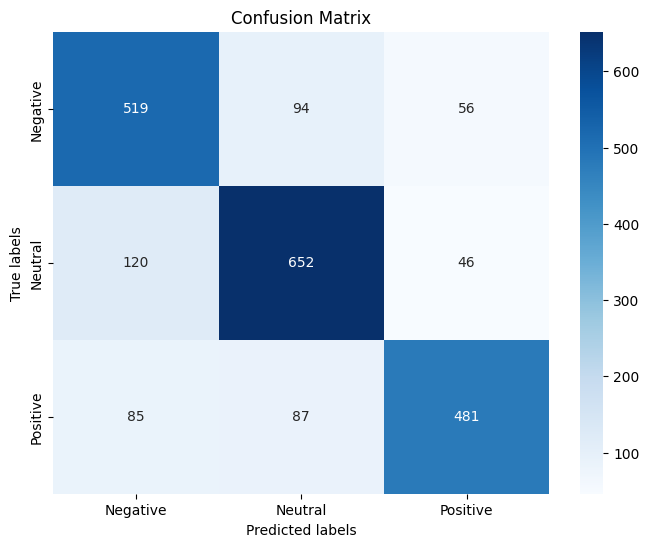

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [100]:
preprocessed_headline = preprocess("Company stock rises on higher Q3 profit")

# Transforming the preprocessed headline into a feature vector
new_headline_vector = vectorizer_tf.transform([preprocessed_headline])

# Using trained model to predict the sentiment of the new headline
predicted_sentiment_num = xgb_clf.predict(new_headline_vector)[0]  # Accessing the first element of the array

# Maping predicted sentiment numerical value to its corresponding label
sentiment_mapping = {0: 'neutral' , 1:  'positive', 2: 'negative'}
predicted_sentiment_label = sentiment_mapping[predicted_sentiment_num]

print(f"The predicted sentiment of the headline 'Company stock rises on higher Q3 profit' is: {predicted_sentiment_label}")

The predicted sentiment of the headline 'Company stock rises on higher Q3 profit' is: positive
